_This notebook contains all the sample code and solutions to the exercises in chapter 11._

# Setup

In [1]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Vanishing/Exploding Gradients Problem

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

Saving figure sigmoid_saturation_plot


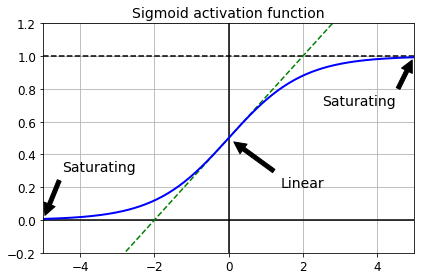

In [3]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()


## Xavier and He Initialization

Note: the book uses `tensorflow.contrib.layers.fully_connected()` rather than `tf.layers.dense()` (which did not exist when this chapter was written). It is now preferable to use `tf.layers.dense()`, because anything in the contrib module may change or be deleted without notice. The `dense()` function is almost identical to the `fully_connected()` function. The main differences relevant to this chapter are:
* several parameters are renamed: `scope` becomes `name`, `activation_fn` becomes `activation` (and similarly the `_fn` suffix is removed from other parameters such as `normalizer_fn`), `weights_initializer` becomes `kernel_initializer`, etc.
* the default `activation` is now `None` rather than `tf.nn.relu`.
* it does not support `tensorflow.contrib.framework.arg_scope()` (introduced later in chapter 11).
* it does not support regularizer params (introduced later in chapter 11).

In [4]:
import tensorflow as tf

In [5]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [6]:
he_init = tf.variance_scaling_initializer()
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                             kernel_initializer=he_init, name="hidden1")

## Nonsaturating Activation Functions

### Leaky ReLU

In [7]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha * z, z)

Saving figure leaky_relu_plot


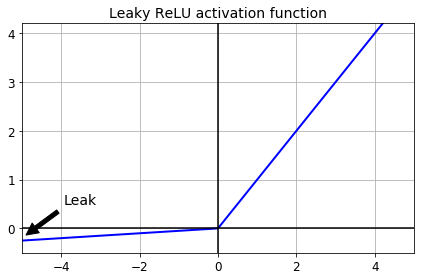

In [8]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

In [9]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [10]:
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")

Let's train a neural network on MNIST using the Leaky ReLU. First let's create the graph:

In [11]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_output = 10

In [12]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [13]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=leaky_relu, name="hidden2")
    logit = tf.layers.dense(hidden2, n_inputs, name="outputs")

In [14]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logit)
    loss = tf.reduce_mean(xentropy, name="loss")

In [15]:
learning_rate = 0.01

with tf.name_scope("train"):
     optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
     training_op = optimizer.minimize(loss)

In [16]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logit, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [17]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Let's load the data:

**Warning**: `tf.examples.tutorials.mnist` is deprecated. We will use `tf.keras.datasets.mnist` instead.

In [18]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [19]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [ ]:
n_epochs = 40
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        i = 0
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_train, y: y_train})
            print ("Epoch:", epoch, "Batch:", i)
            i = i + 1
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_train, y: y_train})
            acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
            print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)
    save_path = saver.save(sess, "./my_model_final.ckpt")

Epoch: 0 Batch: 0
Epoch: 0 Batch: 1
Epoch: 0 Batch: 2
Epoch: 0 Batch: 3
Epoch: 0 Batch: 4
Epoch: 0 Batch: 5
Epoch: 0 Batch: 6
Epoch: 0 Batch: 7
Epoch: 0 Batch: 8
Epoch: 0 Batch: 9
Epoch: 0 Batch: 10
Epoch: 0 Batch: 11
Epoch: 0 Batch: 12
Epoch: 0 Batch: 13
Epoch: 0 Batch: 14
Epoch: 0 Batch: 15
Epoch: 0 Batch: 16
Epoch: 0 Batch: 17
Epoch: 0 Batch: 18
Epoch: 0 Batch: 19
Epoch: 0 Batch: 20
Epoch: 0 Batch: 21
Epoch: 0 Batch: 22
Epoch: 0 Batch: 23
Epoch: 0 Batch: 24
Epoch: 0 Batch: 25
Epoch: 0 Batch: 26
Epoch: 0 Batch: 27
Epoch: 0 Batch: 28
Epoch: 0 Batch: 29
Epoch: 0 Batch: 30
Epoch: 0 Batch: 31
Epoch: 0 Batch: 32
Epoch: 0 Batch: 33
Epoch: 0 Batch: 34
Epoch: 0 Batch: 35
Epoch: 0 Batch: 36
Epoch: 0 Batch: 37
Epoch: 0 Batch: 38
Epoch: 0 Batch: 39
Epoch: 0 Batch: 40
Epoch: 0 Batch: 41
Epoch: 0 Batch: 42
Epoch: 0 Batch: 43
Epoch: 0 Batch: 44
Epoch: 0 Batch: 45
Epoch: 0 Batch: 46
Epoch: 0 Batch: 47
Epoch: 0 Batch: 48
Epoch: 0 Batch: 49
Epoch: 0 Batch: 50
Epoch: 0 Batch: 51
Epoch: 0 Batch: 52
Epo

Epoch: 0 Batch: 416
Epoch: 0 Batch: 417
Epoch: 0 Batch: 418
Epoch: 0 Batch: 419
Epoch: 0 Batch: 420
Epoch: 0 Batch: 421
Epoch: 0 Batch: 422
Epoch: 0 Batch: 423
Epoch: 0 Batch: 424
Epoch: 0 Batch: 425
Epoch: 0 Batch: 426
Epoch: 0 Batch: 427
Epoch: 0 Batch: 428
Epoch: 0 Batch: 429
Epoch: 0 Batch: 430
Epoch: 0 Batch: 431
Epoch: 0 Batch: 432
Epoch: 0 Batch: 433
Epoch: 0 Batch: 434
Epoch: 0 Batch: 435
Epoch: 0 Batch: 436
Epoch: 0 Batch: 437
Epoch: 0 Batch: 438
Epoch: 0 Batch: 439
Epoch: 0 Batch: 440
Epoch: 0 Batch: 441
Epoch: 0 Batch: 442
Epoch: 0 Batch: 443
Epoch: 0 Batch: 444
Epoch: 0 Batch: 445
Epoch: 0 Batch: 446
Epoch: 0 Batch: 447
Epoch: 0 Batch: 448
Epoch: 0 Batch: 449
Epoch: 0 Batch: 450
Epoch: 0 Batch: 451
Epoch: 0 Batch: 452
Epoch: 0 Batch: 453
Epoch: 0 Batch: 454
Epoch: 0 Batch: 455
Epoch: 0 Batch: 456
Epoch: 0 Batch: 457
Epoch: 0 Batch: 458
Epoch: 0 Batch: 459
Epoch: 0 Batch: 460
Epoch: 0 Batch: 461
Epoch: 0 Batch: 462
Epoch: 0 Batch: 463
Epoch: 0 Batch: 464
Epoch: 0 Batch: 465


Epoch: 0 Batch: 826
Epoch: 0 Batch: 827
Epoch: 0 Batch: 828
Epoch: 0 Batch: 829
Epoch: 0 Batch: 830
Epoch: 0 Batch: 831
Epoch: 0 Batch: 832
Epoch: 0 Batch: 833
Epoch: 0 Batch: 834
Epoch: 0 Batch: 835
Epoch: 0 Batch: 836
Epoch: 0 Batch: 837
Epoch: 0 Batch: 838
Epoch: 0 Batch: 839
Epoch: 0 Batch: 840
Epoch: 0 Batch: 841
Epoch: 0 Batch: 842
Epoch: 0 Batch: 843
Epoch: 0 Batch: 844
Epoch: 0 Batch: 845
Epoch: 0 Batch: 846
Epoch: 0 Batch: 847
Epoch: 0 Batch: 848
Epoch: 0 Batch: 849
Epoch: 0 Batch: 850
Epoch: 0 Batch: 851
Epoch: 0 Batch: 852
Epoch: 0 Batch: 853
Epoch: 0 Batch: 854
Epoch: 0 Batch: 855
Epoch: 0 Batch: 856
Epoch: 0 Batch: 857
Epoch: 0 Batch: 858
Epoch: 0 Batch: 859
Epoch: 0 Batch: 860
Epoch: 0 Batch: 861
Epoch: 0 Batch: 862
Epoch: 0 Batch: 863
Epoch: 0 Batch: 864
Epoch: 0 Batch: 865
Epoch: 0 Batch: 866
Epoch: 0 Batch: 867
Epoch: 0 Batch: 868
Epoch: 0 Batch: 869
Epoch: 0 Batch: 870
Epoch: 0 Batch: 871
Epoch: 0 Batch: 872
Epoch: 0 Batch: 873
Epoch: 0 Batch: 874
Epoch: 0 Batch: 875


Epoch: 1 Batch: 134
Epoch: 1 Batch: 135
Epoch: 1 Batch: 136
Epoch: 1 Batch: 137
Epoch: 1 Batch: 138
Epoch: 1 Batch: 139
Epoch: 1 Batch: 140
Epoch: 1 Batch: 141
Epoch: 1 Batch: 142
Epoch: 1 Batch: 143
Epoch: 1 Batch: 144
Epoch: 1 Batch: 145
Epoch: 1 Batch: 146
Epoch: 1 Batch: 147
Epoch: 1 Batch: 148
Epoch: 1 Batch: 149
Epoch: 1 Batch: 150
Epoch: 1 Batch: 151
Epoch: 1 Batch: 152
Epoch: 1 Batch: 153
Epoch: 1 Batch: 154
Epoch: 1 Batch: 155
Epoch: 1 Batch: 156
Epoch: 1 Batch: 157
Epoch: 1 Batch: 158
Epoch: 1 Batch: 159
Epoch: 1 Batch: 160
Epoch: 1 Batch: 161
Epoch: 1 Batch: 162
Epoch: 1 Batch: 163
Epoch: 1 Batch: 164
Epoch: 1 Batch: 165
Epoch: 1 Batch: 166
Epoch: 1 Batch: 167
Epoch: 1 Batch: 168
Epoch: 1 Batch: 169
Epoch: 1 Batch: 170
Epoch: 1 Batch: 171
Epoch: 1 Batch: 172
Epoch: 1 Batch: 173
Epoch: 1 Batch: 174
Epoch: 1 Batch: 175
Epoch: 1 Batch: 176
Epoch: 1 Batch: 177
Epoch: 1 Batch: 178
Epoch: 1 Batch: 179
Epoch: 1 Batch: 180
